# Graph Neural Networks

## Requirements

In [1]:
!pip install histomicstk --find-links https://girder.github.io/large_image_wheels -q
!pip install ogb -q
!pip install gdown -q
!pip install torchvision -q
!pip install torch_geometric -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.2/643.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.0/98.0 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.1/138.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 77.7 MB/s e

## Imports

In [2]:
import histomicstk as htk  # HistomicsTK for pathology image analysis
from histomicstk.preprocessing.color_normalization import deconvolution_based_normalization as deconv_norm
from histomicstk.preprocessing.color_deconvolution import color_deconvolution, stain_color_map
import numpy as np
import scipy as sp
import skimage.io
import skimage.measure
import skimage.color
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import torch.nn as nn
import os
import copy
from PIL import Image
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import models
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Dataset as geometric_Dataset
from torch_geometric.loader import DataLoader as geometric_DataLoader
from torch_geometric.data import Data
# from ogb.graphproppred import Evaluator
from sklearn.metrics import accuracy_score as Evaluator
import gc

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset

The BRACS test dataset, a collection of Hematoxylin and Eosin (H&E) stained histopathological images for breast tumor classification. The dataset includes over 4,000 tumor regions-of-interest labeled in 7 categories.

In [ ]:
!gdown "https://drive.google.com/uc?export=download&id=1Hk7rtmyR65y4ZXUt9fNN_qlv-A8JyJVd" -O data.zip -q
!unzip -qq data.zip
!rm -rf data.zip

## Preprocessing and Graphic Model Extraction

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
base = '/content/data'
# base = '/content/drive/MyDrive/CurrentData/data'
images = []
for root, dirs, files in os.walk(base):
  if files:
    label = root.split('/')[-1].split('_')[0]
    for f in files:
      image_path = os.path.join(base, root, f)
      image = Image.open(image_path)
      if image.size[0] < 224 or image.size[1] < 224 or image.size[0] > 1120 or image.size[1] > 1120: # filtering out small and big images
        continue
      images.append({
          'image': image,
          'label': label
      })

df = pd.DataFrame(images)
df.shape

(150, 2)

In [6]:
def images_preprocess(images):
  normalized = []
  print('Image Normalizing:')
  for image in tqdm(images):
    image = np.array(image)
    stain_unmixing_routine_params = {
      'stains': ['hematoxylin', 'eosin'],
      'stain_unmixing_method': 'macenko_pca'
      }

    stains = ['hematoxylin', 'eosin', 'null']
    W = np.array([stain_color_map[st] for st in stains]).T
    norm_image = deconv_norm(image, W_target=W, stain_unmixing_routine_params=stain_unmixing_routine_params)
    normalized.append(norm_image)

  return normalized


def nuclei_extracting(images):
  print("Nuclei Extracting:")
  stains = ['hematoxylin', 'eosin', 'null']
  W = np.array([stain_color_map[st] for st in stains]).T
  output = []
  for im in tqdm(images):

    im_stains = color_deconvolution(im, W).Stains

    im_nuclei_stain = im_stains[:, :, 0]

    foreground_threshold = 82

    im_fgnd_mask = sp.ndimage.binary_fill_holes(
        im_nuclei_stain < foreground_threshold)

    min_radius = 6
    max_radius = 12

    im_log_max, im_sigma_max = htk.filters.shape.cdog(
        im_nuclei_stain, im_fgnd_mask,
        sigma_min=min_radius * np.sqrt(2),
        sigma_max=max_radius * np.sqrt(2),
    )

    local_max_search_radius = 10

    im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(im_log_max, im_fgnd_mask, local_max_search_radius)

    min_nucleus_area = 70

    im_nuclei_seg_mask = htk.segmentation.label.area_open(
        im_nuclei_seg_mask, min_nucleus_area).astype(np.int32)

    objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

    centroids = []
    for obj in objProps:
      centroids.append(obj.centroid)

    output.append([im_nuclei_seg_mask, objProps, get_edges(centroids)])

  return output

def get_edges(centroids):
  neighboring_threshold = 110
  node_n = len(centroids)
  edges = [[], []]
  for i in range(node_n):
    for j in range(i+1, node_n):
      x1 = centroids[i][0]
      x2 = centroids[j][0]
      y1 = centroids[i][1]
      y2 = centroids[j][1]

      if abs(x1-x2) + abs(y1-y2) <= neighboring_threshold:
        edges[0] += [i, j]
        edges[1] += [j, i]

  return edges

df['image'] = images_preprocess(df['image'])
df[['masks', 'objProps', 'edges']] = nuclei_extracting(df['image'])
gc.collect()

Image Normalizing:


100%|██████████| 150/150 [01:19<00:00,  1.89it/s]


Nuclei Extracting:


100%|██████████| 150/150 [02:13<00:00,  1.12it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


0

## Visualization

Visualize the results to check accuracy and quality. For example, a random pathology image alongside the graph of adjacent nuclei are displayed.


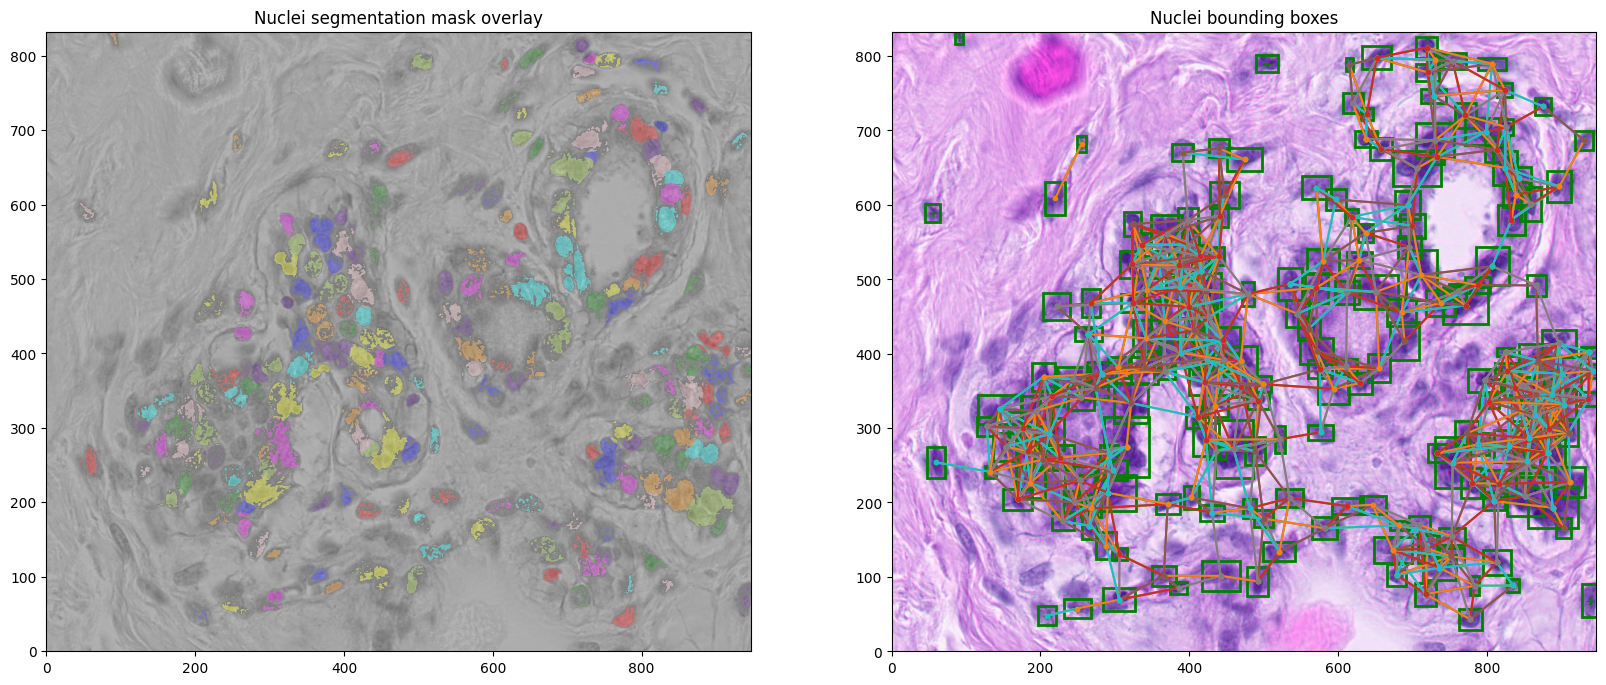

In [ ]:
i = np.random.choice(range(df.shape[0]))
j = np.random.choice(range(len(df.iloc[i]['image'])))
data = df.iloc[i]
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(data['masks'], data['image'], bg_label=0), origin='lower')
plt.title('Nuclei segmentation mask overlay')

plt.subplot(1, 2, 2)
plt.imshow(data['image'])
plt.xlim([0, data['image'].shape[1]])
plt.ylim([0, data['image'].shape[0]])
plt.title('Nuclei bounding boxes')


for i in range(len(data['objProps'])):

    c = [data['objProps'][i].centroid[1], data['objProps'][i].centroid[0], 0]
    width = data['objProps'][i].bbox[3] - data['objProps'][i].bbox[1] + 1
    height = data['objProps'][i].bbox[2] - data['objProps'][i].bbox[0] + 1

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                               width, height, fill=False, ec='g', linewidth=2)

    plt.gca().add_patch(mrect)

for i in range(len(data['edges'][0])):
  x = [data['objProps'][data['edges'][0][i]].centroid[1], data['objProps'][data['edges'][1][i]].centroid[1]]
  y = [data['objProps'][data['edges'][0][i]].centroid[0], data['objProps'][data['edges'][1][i]].centroid[0]]
  plt.plot(x, y, '.-')

## Embedding

In [7]:
class CustomDataset(Dataset):
  def __init__(self, image, objProps, transform):
    self.image = image
    self.objProps = objProps
    self.transform = transform

  def __getitem__(self, id):
    obj = self.objProps[id]
    images = []
    for nucleolus in obj:
      min_row = nucleolus.bbox[0]
      min_col = nucleolus.bbox[1]
      max_row = nucleolus.bbox[2] + 1
      max_col = nucleolus.bbox[3] + 1

      image = self.image[id][min_row:max_row, min_col:max_col, :]
      image = torch.from_numpy(image)
      image = image.permute(2,0,1)
      image = self.transform(image)

      images.append(image)

    return torch.stack(images)

  def __len__(self):
    return self.image.shape[0]

transform = v2.Compose([
    v2.Resize((224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CustomDataset(df['image'], df['objProps'], transform)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [8]:
def get_embeddings(model, dataloader):
  model.eval()
  embeddings = []
  for im in dataloader:
    im = im.to(device)
    im = im.squeeze(0)
    embedding = model(im)
    embeddings.append(embedding.cpu().numpy())
  return embeddings

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model = model.to(device)
for param in model.parameters():
  param.requires_grad = False

df['embeddings'] = get_embeddings(model, dataloader)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


## Dataset Object

Geometric Dataset

In [9]:
class PathologyDataset(geometric_Dataset):
    def __init__(self, data, classes):
        super().__init__(None, None, None)
        self.data = data
        self.num_tasks = classes

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        tempData = self.data.iloc[idx]
        graph = Data(x=torch.tensor(tempData['embeddings']),
                     edge_index=torch.tensor(tempData['edges'], dtype=torch.int32),
                     y=torch.tensor(tempData[['label_0', 'label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6']], dtype=torch.float32))

        return graph
    # def get_idx_split(self):

    #     train_indices = None
    #     test_indices = None
    #     val_indices = None

    #     return {'train': train_indices, 'val': val_indices, 'test': test_indices}

X_train, X_test, y_train, y_test  = train_test_split(
    df[['edges', 'embeddings']],
    df['label'],
    test_size=0.25,
    random_state=0,
    stratify = df['label']
)

test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
test_df = pd.concat([test_df, pd.get_dummies(test_df.label, prefix='label')], axis=1)
test_df.drop('label', axis=1, inplace=True)

train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
X_train, X_val, y_train, y_val  = train_test_split(
    train_df[['edges', 'embeddings']],
    train_df['label'],
    test_size=0.06,
    random_state=1,
    stratify = train_df['label']
)
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
train_df = pd.concat([train_df, pd.get_dummies(train_df.label, prefix='label')], axis=1)
train_df.drop('label', axis=1, inplace=True)

val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
val_df = pd.concat([val_df, pd.get_dummies(val_df.label, prefix='label')], axis=1)
val_df.drop('label', axis=1, inplace=True)

for c in ['label_0','label_1', 'label_2', 'label_3', 'label_4', 'label_5', 'label_6']:
  if c not in val_df.columns:
    val_df[c] = 0
  if c not in test_df.columns:
    test_df[c] = 0

train_dataset = PathologyDataset(train_df, 7)
val_dataset = PathologyDataset(val_df, 7)
test_dataset = PathologyDataset(test_df, 7)

In [10]:
train_loader = geometric_DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = geometric_DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = geometric_DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

0

## GCN Model Implementation

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout, return_embeds=False):

        super(GCN, self).__init__()

        self.num_layers = num_layers

        # A list of GCNConv layers
        self.convs = nn.ModuleList(
            [GCNConv(in_channels=input_dim, out_channels=hidden_dim)] +
            [GCNConv(in_channels=hidden_dim, out_channels=hidden_dim) for i in range(num_layers-2)] +
            [GCNConv(in_channels=hidden_dim, out_channels=output_dim)])

        # A list of 1D batch normalization layers
        self.bns = nn.ModuleList(
            [nn.BatchNorm1d(num_features=hidden_dim) for i in range(num_layers-1)]
            )

        # The log softmax layer
        self.softmax = nn.LogSoftmax()

        # Probability of an element getting zeroed
        self.dropout = dropout

        # Skip classification layer and return node embeddings
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for i in range(self.num_layers-1):
          x = self.convs[i](x, adj_t)
          x = self.bns[i](x)
          x = F.relu(x)
          x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        out = x if self.return_embeds else self.softmax(x)
        return out

## Graph Prediction Model

GCN Graph Prediction model implemented using node embeddings from the GCN model and global pooling to create graph-level embeddings.

### Graph Mini-Batching
Before diving into the actual model, we introduce the concept of mini-batching with graphs. In order to parallelize the processing of a mini-batch of graphs, PyG combines the graphs into a single disconnected graph data object (*torch_geometric.data.Batch*). *torch_geometric.data.Batch* inherits from *torch_geometric.data.Data* (introduced earlier) and contains an additional attribute called `batch`.

The `batch` attribute is a vector mapping each node to the index of its corresponding graph within the mini-batch:

    batch = [0, ..., 0, 1, ..., n - 2, n - 1, ..., n - 1]

This attribute is crucial for associating which graph each node belongs to and can be used to e.g. average the node embeddings for each graph individually to compute graph level embeddings.


### Implemention
Now, we have all of the tools to implement a GCN Graph Prediction model!  

We will reuse the existing GCN model to generate `node_embeddings` and then use  `Global Pooling` over the nodes to create graph level embeddings that can be used to predict properties for the each graph. Remeber that the `batch` attribute will be essential for performining Global Pooling over our mini-batch of graphs.


In [12]:
from torch_geometric.nn import global_add_pool, global_mean_pool

### GCN to predict graph property
class GCN_Graph(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GCN_Graph, self).__init__()

        # Node embedding model
        # Note that the input_dim and output_dim are set to hidden_dim
        self.gnn_node = GCN(input_dim, hidden_dim,
            hidden_dim, num_layers, dropout, return_embeds=True)

        self.pool = global_mean_pool

        # Output layer
        self.linear = torch.nn.Linear(hidden_dim, output_dim)


    def reset_parameters(self):
      self.gnn_node.reset_parameters()
      self.linear.reset_parameters()

    def forward(self, batched_data):
        # NOTE: Since we are predicting graph level properties,
        # output will be a tensor with dimension equaling
        # the number of graphs in the mini-batch

        # Extracting important attributes of our mini-batch
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        embed = self.gnn_node(x, edge_index)
        features = self.pool(embed, batch)
        out = self.linear(features)
        
        return out

In [13]:
def train(model, device, data_loader, optimizer, loss_fn):
    model.train()
    loss = 0

    for step, batch in enumerate(data_loader):
      batch = batch.to(device)
      if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
          pass
      else:
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out, batch.y.reshape(len(batch),-1))
        loss.backward()
        optimizer.step()

    return loss.item()

In [14]:
# The evaluation function
def eval(model, device, loader, evaluator, save_model_results=False, save_file=None):
    model.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(loader):
        batch = batch.to(device)

        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch)

            y_true += [i.item() for i in batch.y.reshape(len(batch), -1).argmax(dim=1, keepdim=True).cpu()]
            y_pred += [i.item() for i in pred.detach().argmax(dim=1, keepdim=True).cpu()]

    if save_model_results:
        print ("Saving Model Predictions")

        data = {}
        data['y_pred'] = y_pred.reshape(-1)
        data['y_true'] = y_true.reshape(-1)

        df = pd.DataFrame(data=data)
        # Saving to csv
        df.to_csv('our_graph_' + save_file + '.csv', sep=',', index=False)

    return evaluator(y_true, y_pred)

## Traing and Testing

In [15]:
evaluator = Evaluator
args = {'device': device, 'input_dim': 1000, 'num_layers': 5, 'hidden_dim': 256, 'dropout': 0.5, 'lr': 0.0001, 'epochs': 30}

In [16]:
model = GCN_Graph(
    args['input_dim'], args['hidden_dim'], train_dataset.num_tasks, args['num_layers'], args['dropout']).to(device)

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.CrossEntropyLoss()

best_model = None
best_valid_acc = 0

train_loss = []
train_acc_hist = []
valid_acc_hist = []
test_acc_hist = []
for epoch in range(1, 1 + args["epochs"]):

    # print('Training...')
    loss = train(model, device, train_loader, optimizer, loss_fn)
    train_loss.append(loss)
    # print('Evaluating...')
    train_acc = eval(model, device, train_loader, evaluator)
    valid_acc = eval(model, device, valid_loader, evaluator)
    test_acc = eval(model, device, test_loader, evaluator)

    train_acc_hist.append(train_acc)
    valid_acc_hist.append(valid_acc)
    test_acc_hist.append(test_acc)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)

    print(f'Epoch {epoch:02d}:\n       Loss: {loss:.4f}, Train Accuracy: {100 * train_acc:.2f}%, Valid Accuracy: {100 * valid_acc:.2f}% Test Accuracy: {100 * test_acc:.2f}%')


Epoch 01:
       Loss: 1.7104, Train Accuracy: 45.71%, Valid Accuracy: 57.14% Test Accuracy: 39.47%
Epoch 02:
       Loss: 1.5442, Train Accuracy: 51.43%, Valid Accuracy: 57.14% Test Accuracy: 47.37%
Epoch 03:
       Loss: 1.5391, Train Accuracy: 55.24%, Valid Accuracy: 57.14% Test Accuracy: 44.74%
Epoch 04:
       Loss: 1.9986, Train Accuracy: 56.19%, Valid Accuracy: 57.14% Test Accuracy: 44.74%
Epoch 05:
       Loss: 1.2043, Train Accuracy: 57.14%, Valid Accuracy: 57.14% Test Accuracy: 50.00%
Epoch 06:
       Loss: 0.9216, Train Accuracy: 68.57%, Valid Accuracy: 71.43% Test Accuracy: 52.63%
Epoch 07:
       Loss: 0.9886, Train Accuracy: 70.48%, Valid Accuracy: 71.43% Test Accuracy: 52.63%
Epoch 08:
       Loss: 0.7475, Train Accuracy: 72.38%, Valid Accuracy: 71.43% Test Accuracy: 55.26%
Epoch 09:
       Loss: 1.0638, Train Accuracy: 73.33%, Valid Accuracy: 71.43% Test Accuracy: 55.26%
Epoch 10:
       Loss: 0.7821, Train Accuracy: 80.00%, Valid Accuracy: 71.43% Test Accuracy: 60.53%


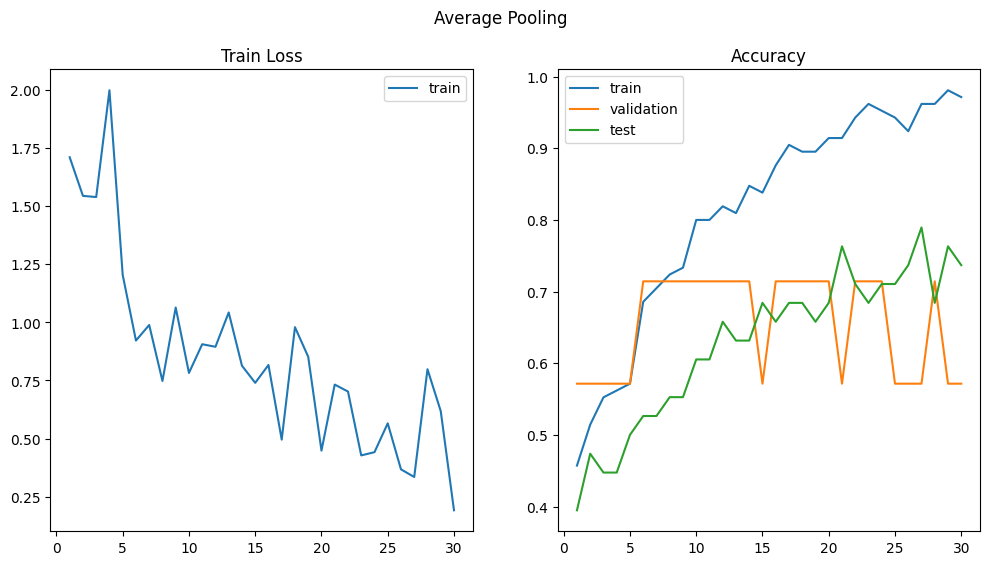

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Average Pooling')
axs[0].plot(np.linspace(1, args["epochs"], args["epochs"]), train_loss, label="train")
axs[1].plot(np.linspace(1, args["epochs"], args["epochs"]), train_acc_hist, label="train")
axs[1].plot(np.linspace(1, args["epochs"], args["epochs"]), valid_acc_hist, label="validation")
axs[1].plot(np.linspace(1, args["epochs"], args["epochs"]), test_acc_hist, label="test")
axs[0].legend()
axs[1].legend()
axs[0].title.set_text('Train Loss')
axs[1].title.set_text('Accuracy')
plt.show()

## Other Experiments

Different global pooling layers in PyTorch Geometric.

**Explanation**

As we can see below, with batch size 16, Average pooling has the best results and converges very well for each epoch. Add pooling generates almost same results for this graph. But Max pooling has the worst results with accuracy almost less than 50% on test dataset and doesn't converge soon, Also has very noisy behavior on loss.

In [19]:
from torch_geometric.nn.pool import global_add_pool

class GCN_Graph(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GCN_Graph, self).__init__()

        self.gnn_node = GCN(input_dim, hidden_dim,
            hidden_dim, num_layers, dropout, return_embeds=True)

        self.pool = global_add_pool

        self.linear = torch.nn.Linear(hidden_dim, output_dim)


    def reset_parameters(self):
      self.gnn_node.reset_parameters()
      self.linear.reset_parameters()

    def forward(self, batched_data):
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        embed = self.gnn_node(x, edge_index)
        features = self.pool(embed, batch)
        out = self.linear(features)

        return out

model = GCN_Graph(
    args['input_dim'], args['hidden_dim'], train_dataset.num_tasks, args['num_layers'], args['dropout']).to(device)

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.CrossEntropyLoss()

best_model = None
best_valid_acc = 0

train_loss = []
train_acc_hist = []
valid_acc_hist = []
test_acc_hist = []
for epoch in range(1, 1 + args["epochs"]):

    loss = train(model, device, train_loader, optimizer, loss_fn)
    train_loss.append(loss)
    train_acc = eval(model, device, train_loader, evaluator)
    valid_acc = eval(model, device, valid_loader, evaluator)
    test_acc = eval(model, device, test_loader, evaluator)

    train_acc_hist.append(train_acc)
    valid_acc_hist.append(valid_acc)
    test_acc_hist.append(test_acc)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)

    print(f'Epoch {epoch:02d}:\n       Loss: {loss:.4f}, Train Accuracy: {100 * train_acc:.2f}%, Valid Accuracy: {100 * valid_acc:.2f}% Test Accuracy: {100 * test_acc:.2f}%')


Epoch 01:
       Loss: 44.1596, Train Accuracy: 18.10%, Valid Accuracy: 14.29% Test Accuracy: 18.42%
Epoch 02:
       Loss: 23.4458, Train Accuracy: 48.57%, Valid Accuracy: 71.43% Test Accuracy: 47.37%
Epoch 03:
       Loss: 42.0792, Train Accuracy: 53.33%, Valid Accuracy: 57.14% Test Accuracy: 50.00%
Epoch 04:
       Loss: 7.0791, Train Accuracy: 60.00%, Valid Accuracy: 57.14% Test Accuracy: 52.63%
Epoch 05:
       Loss: 9.7048, Train Accuracy: 73.33%, Valid Accuracy: 57.14% Test Accuracy: 57.89%
Epoch 06:
       Loss: 0.2417, Train Accuracy: 76.19%, Valid Accuracy: 42.86% Test Accuracy: 50.00%
Epoch 07:
       Loss: 7.1368, Train Accuracy: 82.86%, Valid Accuracy: 42.86% Test Accuracy: 63.16%
Epoch 08:
       Loss: 5.0627, Train Accuracy: 87.62%, Valid Accuracy: 71.43% Test Accuracy: 71.05%
Epoch 09:
       Loss: 1.0858, Train Accuracy: 90.48%, Valid Accuracy: 57.14% Test Accuracy: 68.42%
Epoch 10:
       Loss: 3.4664, Train Accuracy: 89.52%, Valid Accuracy: 57.14% Test Accuracy: 68.4

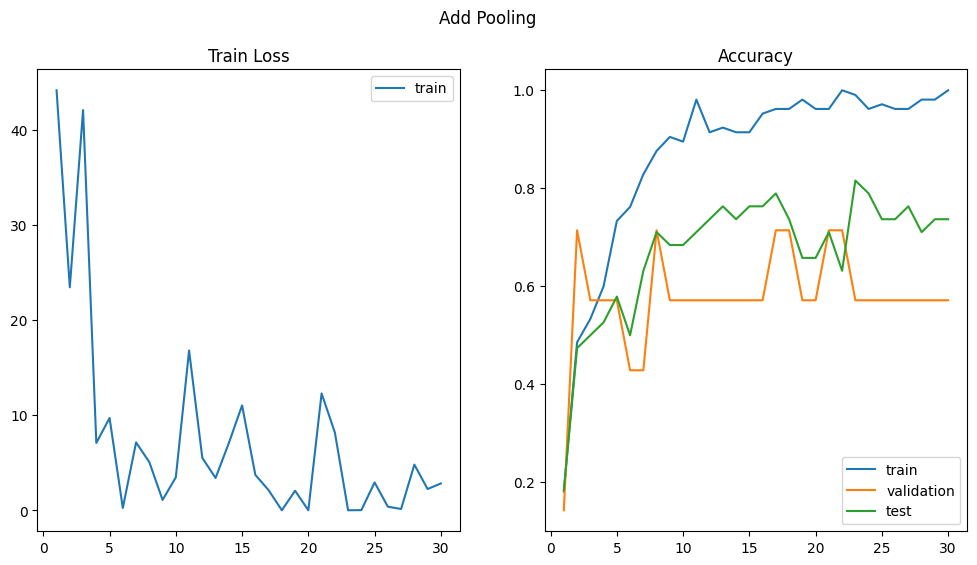

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Add Pooling')
axs[0].plot(np.linspace(1, args["epochs"], args["epochs"]), train_loss, label="train")
axs[1].plot(np.linspace(1, args["epochs"], args["epochs"]), train_acc_hist, label="train")
axs[1].plot(np.linspace(1, args["epochs"], args["epochs"]), valid_acc_hist, label="validation")
axs[1].plot(np.linspace(1, args["epochs"], args["epochs"]), test_acc_hist, label="test")
axs[0].legend()
axs[1].legend()
axs[0].title.set_text('Train Loss')
axs[1].title.set_text('Accuracy')
plt.show()

In [21]:
from torch_geometric.nn.pool import global_max_pool
import warnings
warnings.filterwarnings("ignore")

class GCN_Graph(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GCN_Graph, self).__init__()

        self.gnn_node = GCN(input_dim, hidden_dim,
            hidden_dim, num_layers, dropout, return_embeds=True)

        self.pool = global_max_pool

        self.linear = torch.nn.Linear(hidden_dim, output_dim)


    def reset_parameters(self):
      self.gnn_node.reset_parameters()
      self.linear.reset_parameters()

    def forward(self, batched_data):
        x, edge_index, batch = batched_data.x, batched_data.edge_index, batched_data.batch
        embed = self.gnn_node(x, edge_index)
        features = self.pool(embed, batch)
        out = self.linear(features)

        return out

model = GCN_Graph(
    args['input_dim'], args['hidden_dim'], train_dataset.num_tasks, args['num_layers'], args['dropout']).to(device)

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = torch.nn.CrossEntropyLoss()

best_model = None
best_valid_acc = 0

train_loss = []
train_acc_hist = []
valid_acc_hist = []
test_acc_hist = []
for epoch in range(1, 1 + args["epochs"]):

    loss = train(model, device, train_loader, optimizer, loss_fn)
    train_loss.append(loss)
    train_acc = eval(model, device, train_loader, evaluator)
    valid_acc = eval(model, device, valid_loader, evaluator)
    test_acc = eval(model, device, test_loader, evaluator)

    train_acc_hist.append(train_acc)
    valid_acc_hist.append(valid_acc)
    test_acc_hist.append(test_acc)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model)

    print(f'Epoch {epoch:02d}:\n       Loss: {loss:.4f}, Train Accuracy: {100 * train_acc:.2f}%, Valid Accuracy: {100 * valid_acc:.2f}% Test Accuracy: {100 * test_acc:.2f}%')


Epoch 01:
       Loss: 1.5760, Train Accuracy: 18.10%, Valid Accuracy: 28.57% Test Accuracy: 13.16%
Epoch 02:
       Loss: 2.7599, Train Accuracy: 17.14%, Valid Accuracy: 14.29% Test Accuracy: 18.42%
Epoch 03:
       Loss: 3.1350, Train Accuracy: 38.10%, Valid Accuracy: 28.57% Test Accuracy: 39.47%
Epoch 04:
       Loss: 2.7809, Train Accuracy: 47.62%, Valid Accuracy: 57.14% Test Accuracy: 42.11%
Epoch 05:
       Loss: 2.1498, Train Accuracy: 49.52%, Valid Accuracy: 57.14% Test Accuracy: 44.74%
Epoch 06:
       Loss: 1.7865, Train Accuracy: 53.33%, Valid Accuracy: 57.14% Test Accuracy: 42.11%
Epoch 07:
       Loss: 1.4667, Train Accuracy: 54.29%, Valid Accuracy: 57.14% Test Accuracy: 39.47%
Epoch 08:
       Loss: 2.5100, Train Accuracy: 55.24%, Valid Accuracy: 71.43% Test Accuracy: 39.47%
Epoch 09:
       Loss: 2.4377, Train Accuracy: 56.19%, Valid Accuracy: 71.43% Test Accuracy: 39.47%
Epoch 10:
       Loss: 2.3040, Train Accuracy: 56.19%, Valid Accuracy: 71.43% Test Accuracy: 36.84%


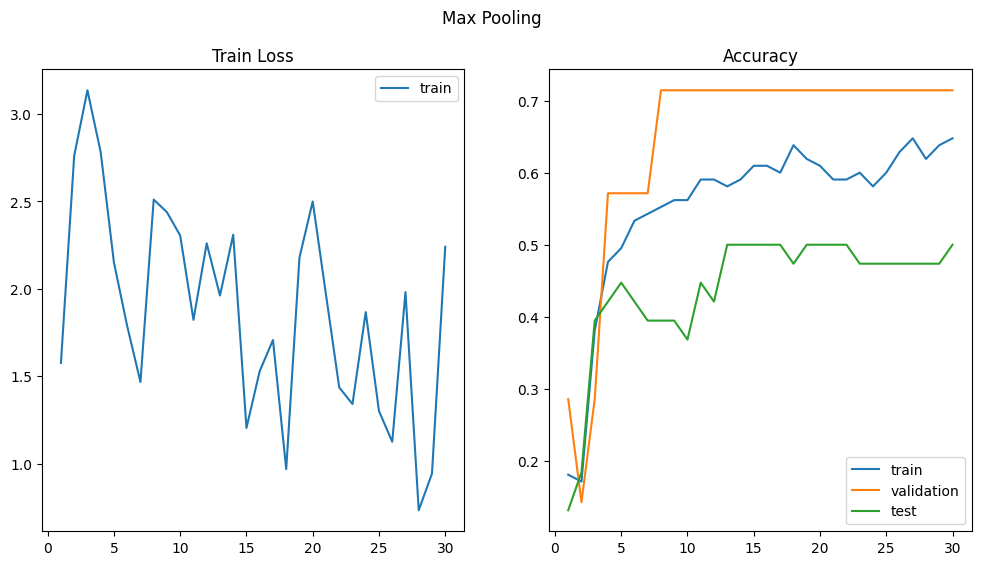

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Max Pooling')
axs[0].plot(np.linspace(1, args["epochs"], args["epochs"]), train_loss, label="train")
axs[1].plot(np.linspace(1, args["epochs"], args["epochs"]), train_acc_hist, label="train")
axs[1].plot(np.linspace(1, args["epochs"], args["epochs"]), valid_acc_hist, label="validation")
axs[1].plot(np.linspace(1, args["epochs"], args["epochs"]), test_acc_hist, label="test")
axs[0].legend()
axs[1].legend()
axs[0].title.set_text('Train Loss')
axs[1].title.set_text('Accuracy')
plt.show()